In [88]:
from __future__ import division
import numpy as np
import matplotlib.pyplot as plt

intp = 1  #tomar uno de cada cien valores, para graficar rapido

# Load data from the .txt file
#ssh -Y cic@148.204.66.123
#ssh -Y alex@148.204.66.53

#source ~/miniconda3/bin/activate
#python3 tb_4x8x4_proc.py
#scp alex@148.204.66.53:'/home/cic/Desktop/EDA/SNN_IPN/sim_results/*.pdf' .
#scp cic@148.204.66.123:'/home/cic/Desktop/EDA/SNN_IPN/sim_results/*.pdf' .

#scp alex@148.204.66.53:/home/alex/.xschem/simulations/data.raw .
#scp alex@148.204.66.53:/home/alex/Desktop/EDA/SNN_IPN/sim_results/tb_4x8x4_data.txt . 
#scp cic@148.204.66.123:/home/cic/Desktop/EDA/SNN_IPN/sim_results/tb_4x8x4_data.txt  .

BSIZE_SP = 512 # Max size of a line of data; we don't want to read the
               # whole file to find a line, in case file does not have
               # expected structure.

MDATA_LIST = [b'title', b'date', b'plotname', b'flags', b'no. variables',
              b'no. points', b'dimensions', b'command', b'option']

def rawread(fname: str):
    """Read ngspice binary raw files. Return tuple of the data, and the
    plot metadata. The dtype of the data contains field names. This is
    not very robust yet, and only supports ngspice.
    
    >>> darr, mdata = rawread('test.py')
    >>> darr.dtype.names
    >>> plot(np.real(darr['frequency']), np.abs(darr['v(out)']))
    """
    # Example header of raw file
    # Title: rc band pass example circuit
    # Date: Sun Feb 21 11:29:14  2016
    # Plotname: AC Analysis
    # Flags: complex
    # No. Variables: 3
    # No. Points: 41
    # Variables:
    #         0       frequency       frequency       grid=3
    #         1       v(out)  voltage
    #         2       v(in)   voltage
    # Binary:
    fp = open(fname, 'rb')
    arrs = []
    plots = []
    plot = {}
    while (True):
        try:
            # mdata = fp.readline(BSIZE_SP).split(b':', maxsplit=1)
            mdata = fp.readline().split(b':', maxsplit=1)
        except:
            raise
        if len(mdata) == 2:
            if mdata[0].lower() in MDATA_LIST:
                plot[mdata[0].lower()] = mdata[1].strip()
            if mdata[0].lower() == b'variables':
                nvars = int(plot[b'no. variables'])
                npoints = int(plot[b'no. points'])
                plot['varnames'] = []
                plot['varunits'] = []
                for varn in range(nvars):
                    # varspec = (fp.readline(BSIZE_SP).strip().decode('ascii').split())
                    varspec = (fp.readline().strip().decode('ascii').split())
                    assert(varn == int(varspec[0]))
                    plot['varnames'].append(varspec[1])
                    plot['varunits'].append(varspec[2])
            if mdata[0].lower() == b'binary':
                rowdtype = np.dtype({'names': plot['varnames'],
                                     'formats': [np.complex_ if b'complex'
                                                 in plot[b'flags']
                                                 else np.float_]*nvars})
                # We should have all the metadata by now
                arrs.append(np.fromfile(fp, dtype=rowdtype, count=npoints))
                plots.append(plot)
                plot = {} # reset the plot dict
                fp.readline() # Read to the end of line
        else:
            break
    return (arrs[0], plots)


    

In [89]:
data, plots = rawread("data.raw")


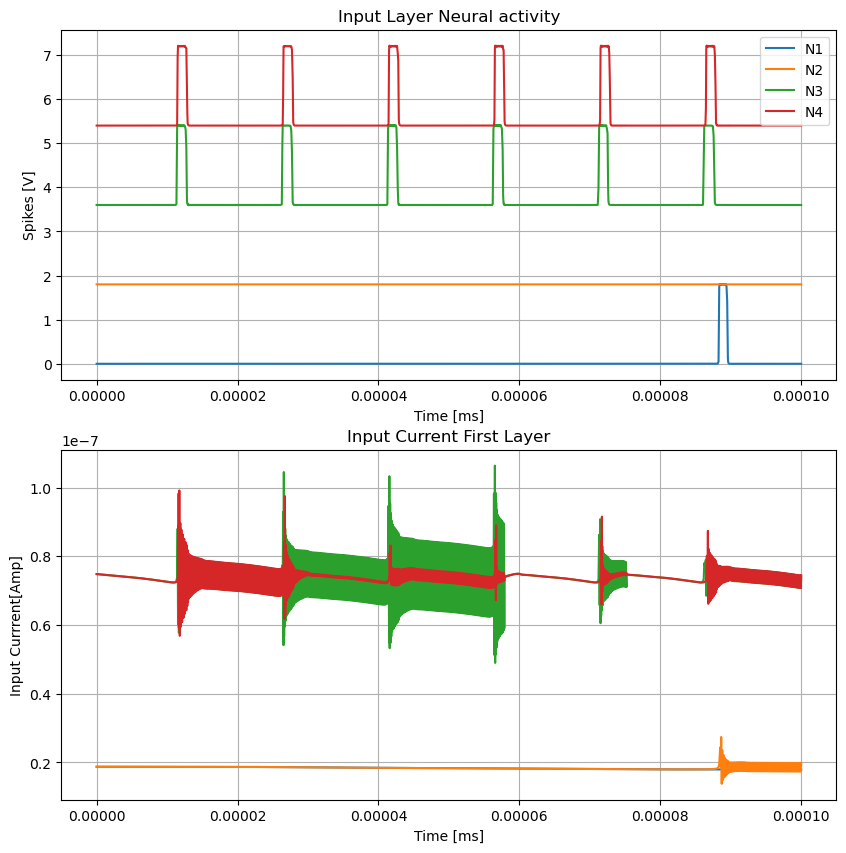

In [90]:
fig, (ax1, ax2) = plt.subplots(2, figsize=(10,10))
for k in range(4):
    nodo = "v(n" +  str(k+1) + ")"
    ax1.plot(data["time"][::intp], data[nodo][::intp]+(1.8*k), label = f"N{k+1}")

ax1.legend()
ax1.grid()
ax1.set_xlabel("Time [ms]")
ax1.set_ylabel("Spikes [V]")
ax1.set_title("Input Layer Neural activity")


for k in range(4):
    Iext_label = "i(v.x1.x" + str(k+1)+ ".vext)"
    ax2.plot(data["time"][::intp], data[Iext_label][::intp], label = f"i{k+1}")

ax2.grid()
ax2.set_xlabel("Time [ms]")
ax2.set_ylabel("Input Currrent[Amp]")
ax2.set_title("Input Current First Layer")
# ax.set_ylim((-0, 3e-6))

fig.savefig('InputLayer.pdf')

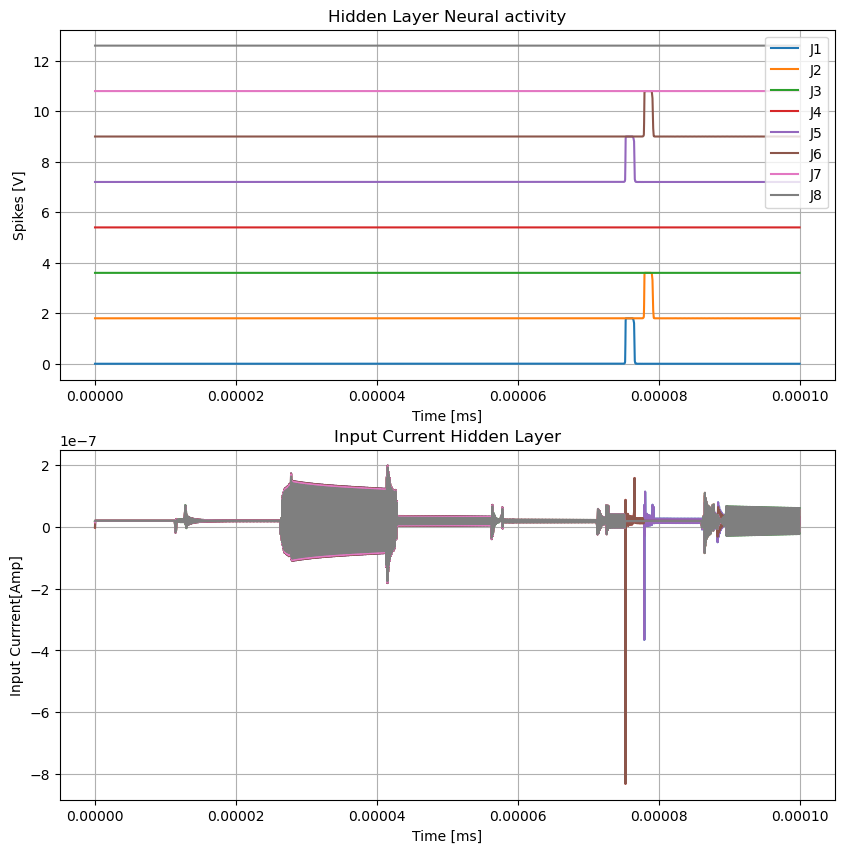

In [91]:


fig, [ax1, ax2] = plt.subplots(2, figsize=(10,10))
for k in range(8):
    nodo = "v(j" +  str(k+1) + ")"
    ax1.plot(data["time"][::intp], data[nodo][::intp]+(1.8*k), label = f"J{k+1}")
ax1.legend()
ax1.grid()
ax1.set_xlabel("Time [ms]")
ax1.set_ylabel("Spikes [V]")
ax1.set_title("Hidden Layer Neural activity")


for k in range(8):
    Iext_label = "i(v.x4.x" + str(k+1)+ ".vext)"
    ax2.plot(data["time"][::intp], data[Iext_label][::intp], label = f"i{k+1}")

ax2.grid()
ax2.set_xlabel("Time [ms]")
ax2.set_ylabel("Input Currrent[Amp]")
ax2.set_title("Input Current Hidden Layer")
# ax.set_ylim((-0.5e-6, 3e-6))
fig.savefig('HiddenLayer.pdf')

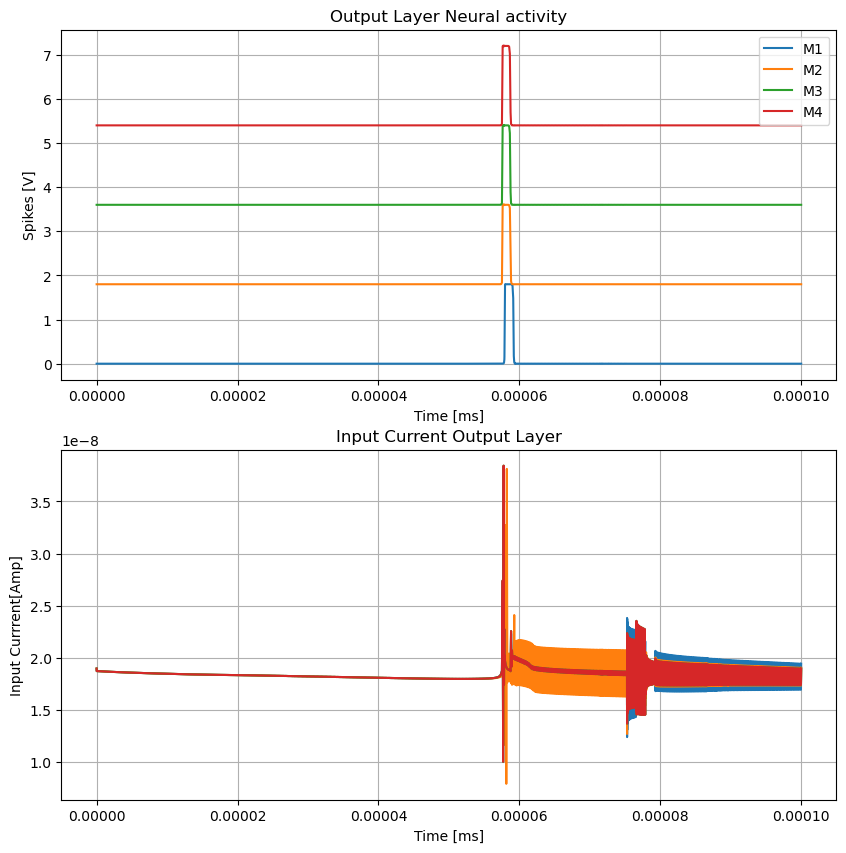

In [92]:


fig, [ax1, ax2] = plt.subplots(2, figsize=(10,10))
for k in range(4):
    nodo = "v(m" +  str(k+1) + ")"
    ax1.plot(data["time"][::intp], data[nodo][::intp]+(1.8*k), label = f"M{k+1}")
ax1.legend()
ax1.grid()
ax1.set_xlabel("Time [ms]")
ax1.set_ylabel("Spikes [V]")
ax1.set_title("Output Layer Neural activity")

for k in range(4):
    Iext_label = "i(v.x2.x" + str(k+1)+ ".vext)"
    ax2.plot(data["time"][::intp], data[Iext_label][::intp], label = f"i{k+1}")

ax2.grid()
ax2.set_xlabel("Time [ms]")
ax2.set_ylabel("Input Currrent[Amp]")
ax2.set_title("Input Current Output Layer")
# ax.set_ylim((-0.5e-7, 5e-6))

fig.savefig('OutputLayer.pdf')

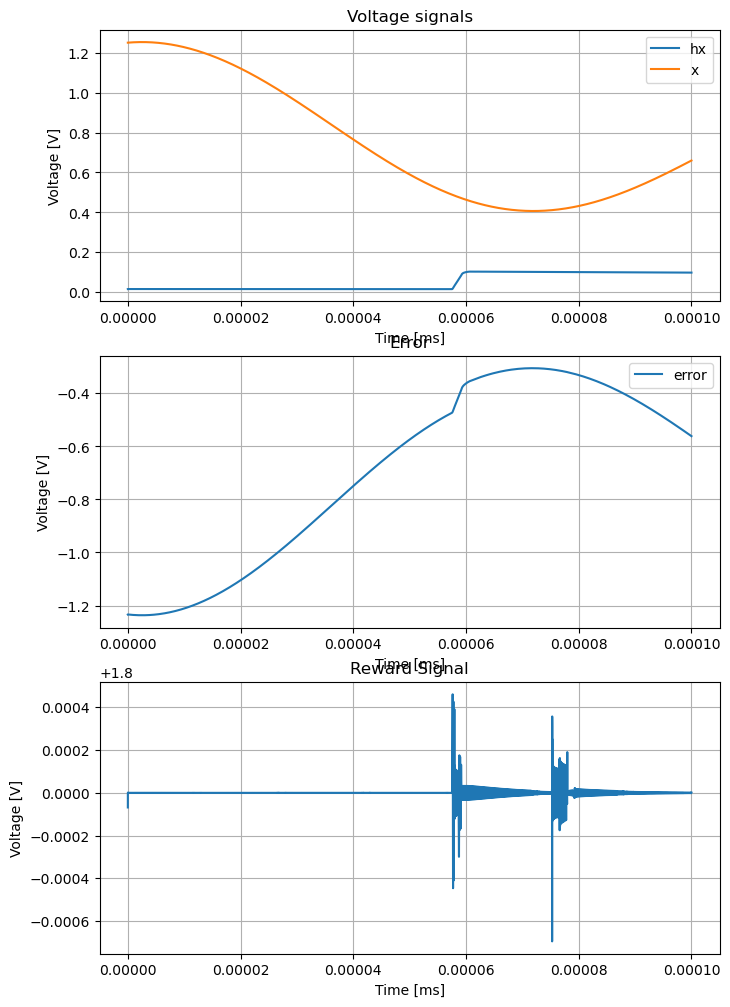

In [93]:
fig, [ax1, ax2, ax3] = plt.subplots(3, figsize=(8,12))

ax1.plot(data["time"][::intp], data["v(hx)"][::intp], label = "hx")
ax1.plot(data["time"][::intp], data["v(x)"][::intp], label = "x")
ax1.legend()
ax1.grid()
ax1.set_xlabel("Time [ms]")
ax1.set_ylabel("Voltage [V]")
ax1.set_title("Voltage signals")


ax2.plot(data["time"][::intp], data["v(hx)"][::intp] - data["v(x)"][::intp], label = "error")
ax2.legend()
ax2.grid()
ax2.set_xlabel("Time [ms]")
ax2.set_ylabel("Voltage [V]")
ax2.set_title("Error")

ax3.plot(data["time"][::intp], data["v(vr1)"][::intp], label = "Vr1")
ax3.set_xlabel("Time [ms]")
ax3.set_ylabel("Voltage [V]")
ax3.set_title("Reward Signal")
ax3.grid()
fig.savefig('Signals.pdf')

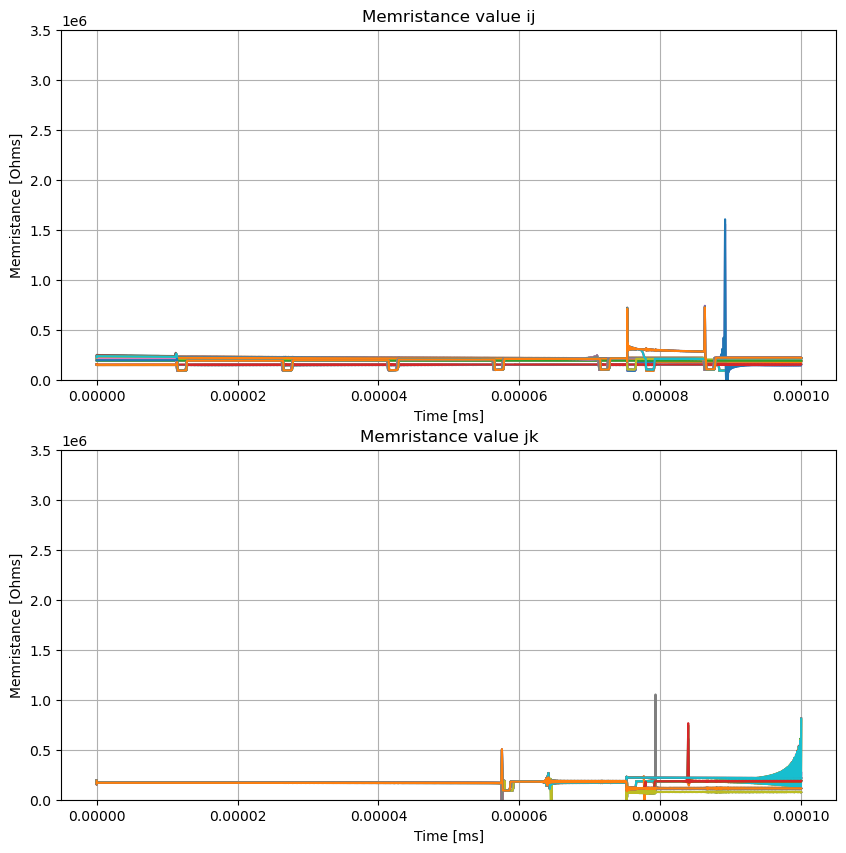

In [94]:

fig, [ax1, ax2] = plt.subplots(2, figsize=(10,10))
for k in range(32):
    Imem_label = "i(v.x5.xstdp" +  str(k+1) + ".vmr)"
    Vte_label = "v(x5.xstdp" +  str(k+1) + ".te)"
    Vbe_label = "v(x5.xstdp" +  str(k+1) + ".be)"
    Imem= data[Imem_label][::intp]
    Vte = data[Vte_label][::intp]
    Vbe = data[Vbe_label][::intp]
    mem = (Vbe -  Vte)/Imem 
    ax1.plot(data["time"][::intp], mem, label = f"ij{k+1}")
    
# ax.legend()
ax1.grid()
ax1.set_xlabel("Time [ms]")
ax1.set_ylabel("Memristance [Ohms]")
ax1.set_title("Memristance value ij")
ax1.set_ylim((0, 3.5e6))

for k in range(32):
    Imem_label = "i(v.x6.xrstdp" +  str(k+1) + ".vmr)"
    Vte_label =  "v(x6.xrstdp" +  str(k+1) + ".te)"
    Vbe_label = "v(x6.xrstdp" +  str(k+1) + ".be)"
    Imem= data[Imem_label][::intp]
    Vte = data[Vte_label][::intp]
    Vbe = data[Vbe_label][::intp]
    mem = (Vbe - Vte)/Imem 
    ax2.plot(data["time"][::intp], mem, label = f"jk{k+1}")


# ax.legend()
ax2.grid()
ax2.set_xlabel("Time [ms]")
ax2.set_ylabel("Memristance [Ohms]")
ax2.set_title("Memristance value jk")
ax2.set_ylim((0, 3.5e6))
fig.savefig('weights.pdf')